In [155]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config3"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

In [95]:
hm = 6
window_dim = hm/2/4
velTenMeters = 4

velocity_scaling = 1/velTenMeters
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df


In [96]:
run = 1
qoisOutputed = ["mass_flux", "comp(u,0)"]
qois= ["mass_flux"]

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

# probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed)
# probes.to_parquet(overwrite = True)

probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")



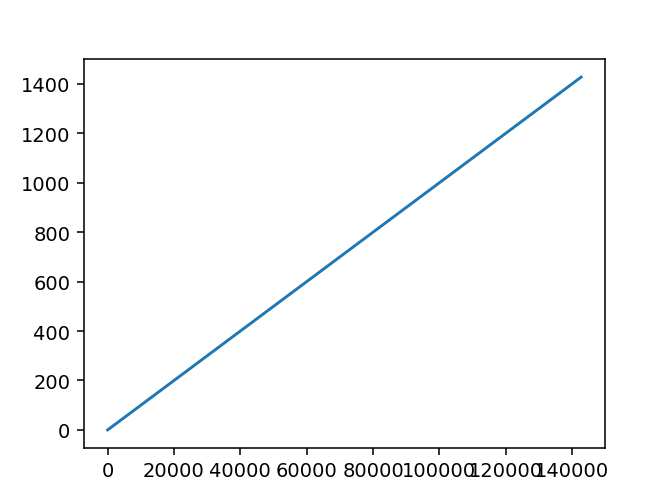

In [97]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [98]:
start = -30000
stop = -1
by = 1

In [99]:
# plt.figure()
# foo_mass = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[0])].compute()
# foo_u = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[1])].compute()
# foo_area = probes.areas["xwindow_0-0_h_3-0_Bx"]
# plt.plot(foo_mass.values/foo_u.values)
# plt.ylim(0,1.225*2)


In [100]:
# plt.figure()
# N = len(foo_mass)
# f, E = sp.signal.welch(foo_mass.values, fs = probes.dt, axis = 0, nperseg = N//4, scaling = 'density', detrend = 'constant') 
# plt.loglog(f, E)

## X Flow


In [101]:
@utils.no_kwargs
def norm_norm_blocks(data_dict):
    if category == "config2":
        return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bz" in name], -1)
    return data_dict

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "xwindow_" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_blocks],
#     parrallel=True
#     )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

x_flowStats = pd.concat([x_mean, x_rms, x_net], axis = "index").T
x_flowStats.columns = ["mean", "rms", "net"]

processing data took 3 seconds
processing data took 2 seconds
processing data took 2 seconds


In [102]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows', bbox = "tight")

# x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
# x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
# x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


In [103]:
@utils.no_kwargs
def norm_norm_windows(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if fnmatch(name, "*window_?-1*")], -1)

@utils.no_kwargs
def norm_norm_blocks(data_dict):
    if category == "config2":
        return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bx" in name], -1)
    return data_dict

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "zwindow" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_windows, norm_norm_blocks],
#     parrallel=True
#     )

## mean statistics
z_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, norm_norm_windows, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

z_flowStats = pd.concat([z_mean, z_rms, z_net], axis = "index").T
z_flowStats.columns = ["mean", "rms", "net"]

processing data took 10 seconds
processing data took 5 seconds
processing data took 5 seconds


In [104]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows', bbox_inches = "tight")

# z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
# z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
# z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Y Flow


In [105]:
# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "skylight" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_skylights],
#     parrallel=True
#     )

## mean statistics
y_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_average, flip_data],
    parrallel=False
    )

## rms statistics
y_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.time_rms],
    parrallel=False
    )

## Net flow
y_net = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, abs_values, probePost.time_average],
    parrallel=False
    )

y_flowStats = pd.concat([y_mean, y_rms, y_net], axis = "index").T
y_flowStats.columns = ["mean", "rms", "net"]

processing data took 2 seconds
processing data took 1 seconds
processing data took 1 seconds


In [106]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/ywindows')

# y_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ymean.csv')
# y_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/yrms.csv')
# y_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ynet.csv')

## All Flow

In [129]:
flowStats = pd.concat([x_flowStats, y_flowStats, z_flowStats], axis = "index")
flowStats = probePost.addWindowDetails(flowStats, probes.get_avg_locations(), probes.areas)
flowStats


,mean,rms,net,windowType,houseType,blockType,area,x,y,z
xwindow_0-0_h_0--1,0.262602,0.090680,0.262602,xwindow_0-0,0--1,,0.568967,72.076505,1.498001,51.997830
xwindow_0-0_h_0--1_Bx,0.120111,0.097658,0.135341,xwindow_0-0,0--1,Bx,0.562706,-52.001926,1.498001,72.006591
xwindow_0-0_h_0--1_Bxz,-0.053997,0.063359,0.069019,xwindow_0-0,0--1,Bxz,0.565125,-72.074645,1.498000,-52.000223
xwindow_0-0_h_0--1_Bz,-0.429522,0.164583,0.430946,xwindow_0-0,0--1,Bz,0.567215,51.999041,1.498001,-72.004937
xwindow_0-0_h_0--2,0.224136,0.088641,0.225666,xwindow_0-0,0--2,,0.568519,84.061313,1.497996,16.004073
...,...,...,...,...,...,...,...,...,...,...
zwindow_2-1_h_0-2_Bz,-0.346082,0.070987,0.346082,zwindow_2-1,0-2,Bz,0.564368,165.946390,1.497985,-94.000088
zwindow_2-1_sl,0.006166,0.075393,0.058418,zwindow_2-1,sl,,0.567006,69.999008,1.498000,93.975152
zwindow_2-1_sl_Bx,0.500152,0.118131,0.500152,zwindow_2-1,sl,Bx,0.570007,-93.973365,1.497997,70.001032
zwindow_2-1_sl_Bxz,0.127799,0.124643,0.156534,zwindow_2-1,sl,Bxz,0.562491,-70.001995,1.498000,-93.969758


In [136]:

roomQois = ["mean", "net"]

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
       ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}

roomVentilation = probePost.roomStatistics(flowStats, connectedWindows, roomQois)
flowStats = flowStats.sort_values(by = ["roomType"])
roomVentilation = roomVentilation.sort_values(by = ["roomType"])
display(roomVentilation)
flowStats

,mean,net,contResid,houseType,blockType,roomType,x,y,z
corner_h_0--1,0.264746,0.264746,-0.004287,0--1,,corner,73.037757,1.498001,51.016070
corner_sl_Bxz,0.039867,0.083194,-0.000969,sl,Bxz,corner,-61.356506,1.995948,-87.334733
corner_sl_Bx,0.140719,0.184826,-0.003216,sl,Bx,corner,-87.349709,2.000950,61.364962
corner_sl,0.372618,0.392527,-0.00824,sl,,corner,61.355144,1.994010,87.334548
corner_h_0-2_Bz,0.34182,0.34761,0.007241,0-2,Bz,corner,159.010725,1.498000,-85.017713
...,...,...,...,...,...,...,...,...,...
single_h_0-1,0.000199,0.000316,-0.000398,0-1,,single,77.997992,1.498000,122.096430
single_h_0-1_Bx,0.000138,0.000265,0.000277,0-1,Bx,single,-122.065580,1.498000,77.999008
single_h_0-1_Bxz,0.000249,0.000311,-0.000498,0-1,Bxz,single,-78.001564,1.498000,-122.094750
single_h_0--2_Bxz,0.00039,0.000416,-0.00078,0--2,Bxz,single,-89.999996,1.498000,-14.058868


,mean,rms,net,windowType,houseType,blockType,area,x,y,z,roomType
xwindow_0-0_h_0--1,0.262602,0.090680,0.262602,xwindow_0-0,0--1,,0.568967,72.076505,1.498001,51.997830,corner
skylight_0-0_sl_Bz,0.107835,0.097378,0.120620,skylight_0-0,sl,Bz,0.565356,87.997084,2.996553,-62.001774,corner
zwindow_0-0_h_0--1,-0.266890,0.091497,0.266890,zwindow_0-0,0--1,,0.567006,73.999008,1.498000,50.034309,corner
zwindow_0-0_h_0--1_Bx,-0.120254,0.097993,0.135558,zwindow_0-0,0--1,Bx,0.567129,-50.032948,1.497995,73.998926,corner
zwindow_0-0_h_0--1_Bxz,0.052521,0.062711,0.067695,zwindow_0-0,0--1,Bxz,0.562491,-74.001995,1.498000,-50.035752,corner
...,...,...,...,...,...,...,...,...,...,...,...
zwindow_1-0_h_0--1_Bxz,-0.000161,0.000809,0.000609,zwindow_1-0,0--1,Bxz,0.562491,-78.001995,1.498000,-50.031412,single
zwindow_1-0_h_0--1_Bx,0.000746,0.000857,0.000855,zwindow_1-0,0--1,Bx,0.56815,-50.032598,1.497997,77.999779,single
zwindow_1-0_h_0--1,-0.000510,0.000787,0.000703,zwindow_1-0,0--1,,0.567006,77.999008,1.498000,50.033324,single
zwindow_1-0_h_0--2_Bz,-0.000598,0.000935,0.000787,zwindow_1-0,0--2,Bz,0.562491,14.076894,1.498000,-89.999996,single


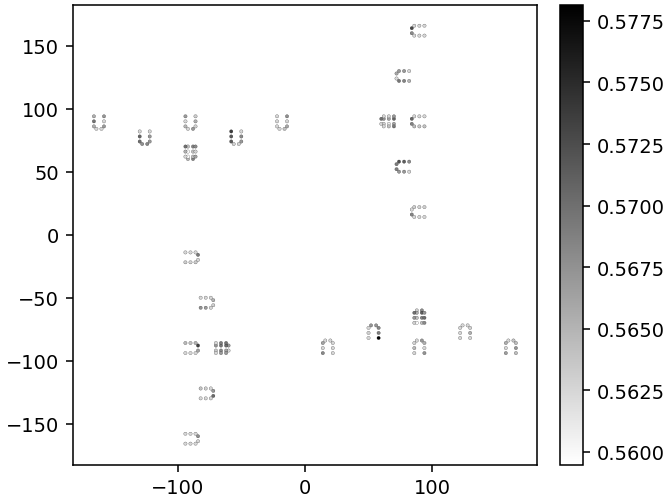

In [133]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["area"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

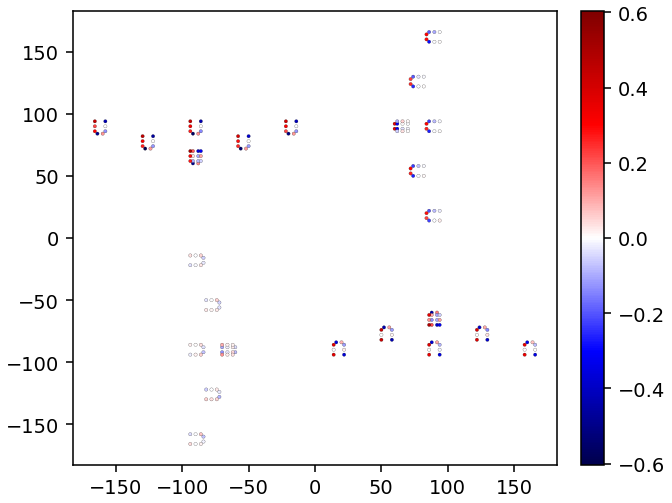

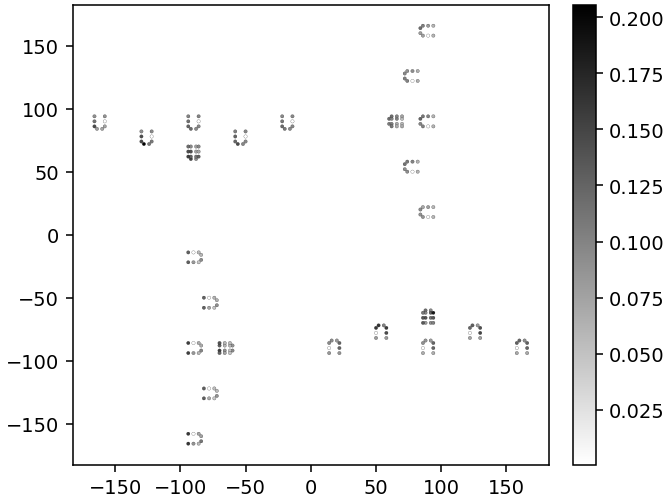

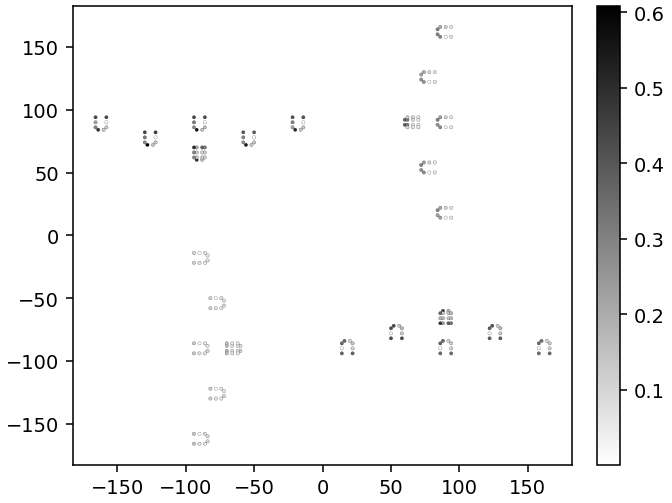

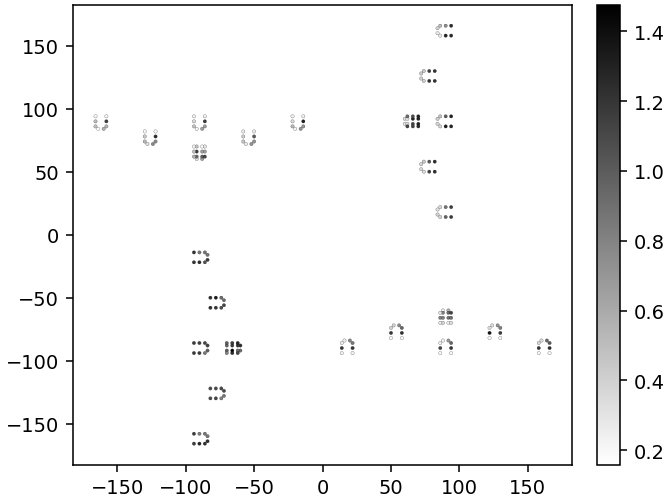

In [110]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm=colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms"]/flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsOnetInterior', bbox_inches="tight")

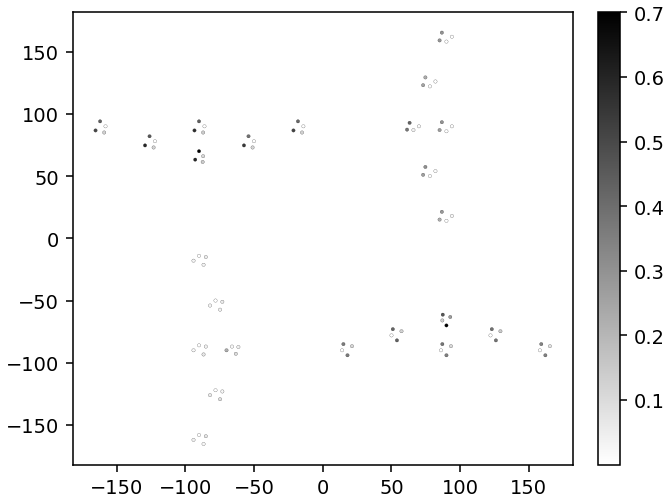

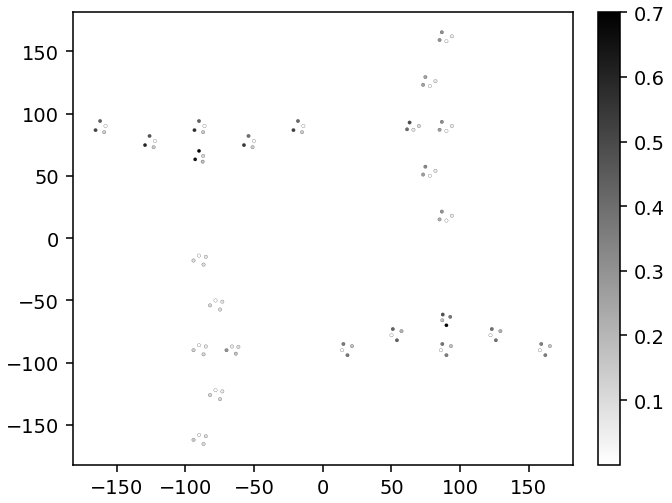

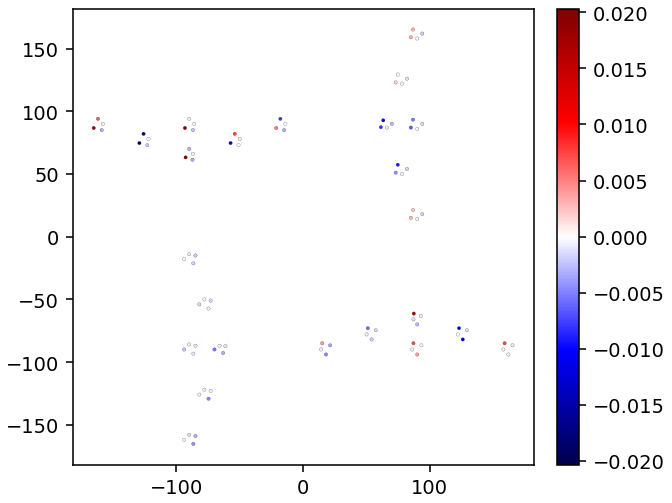

In [111]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["contResid"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/residRooms', bbox_inches="tight")

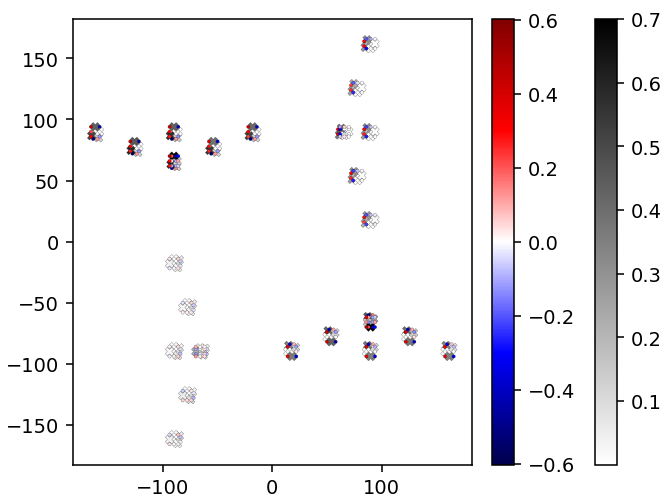

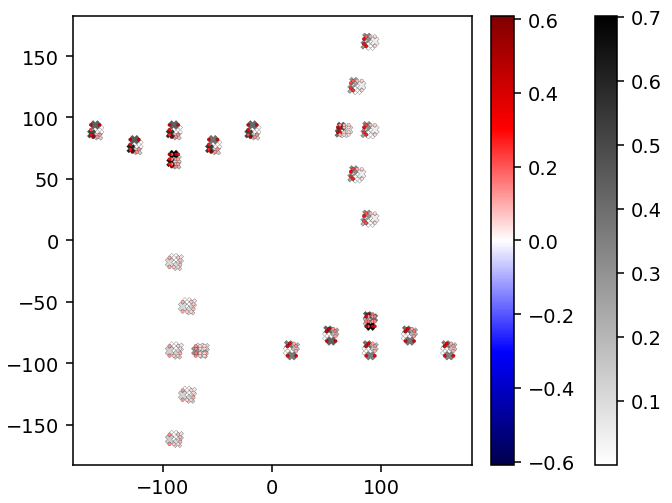

In [112]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowsRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowsRooms', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarni

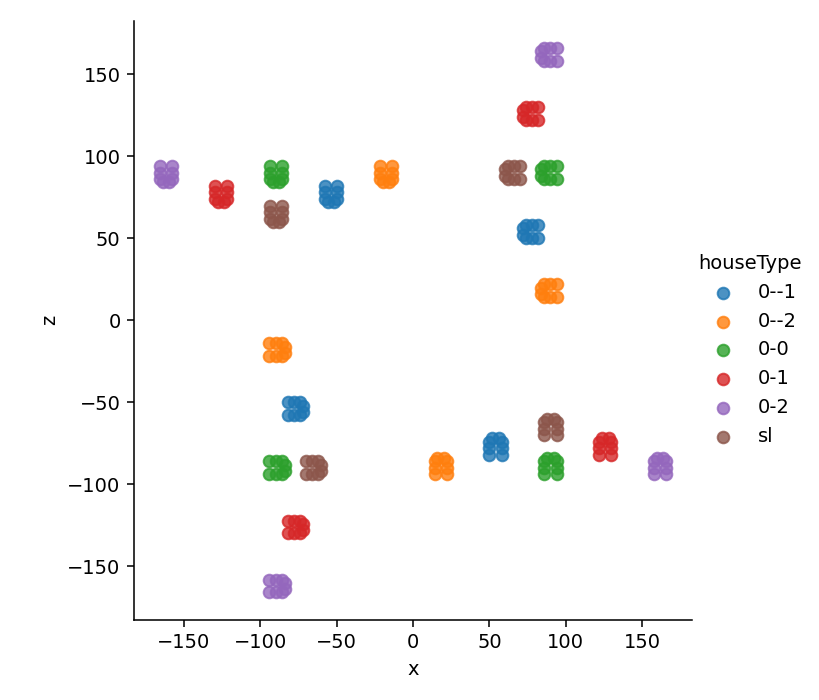

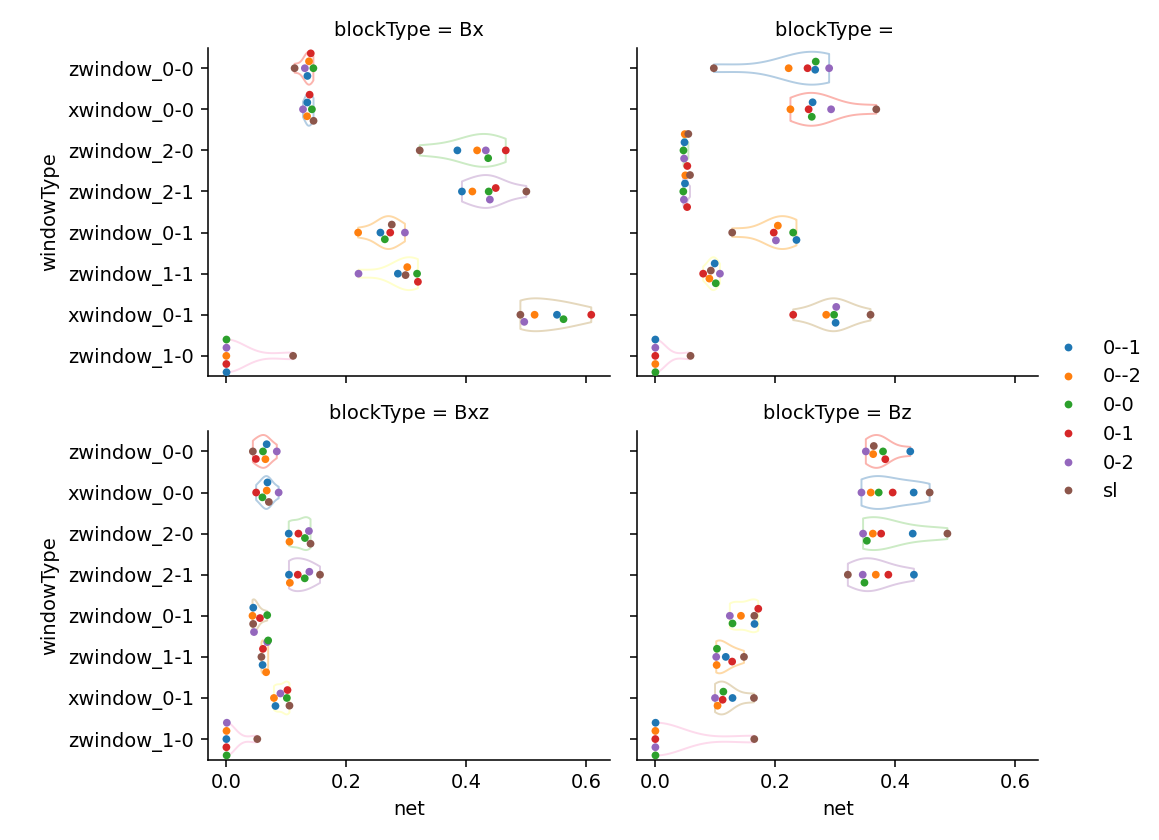

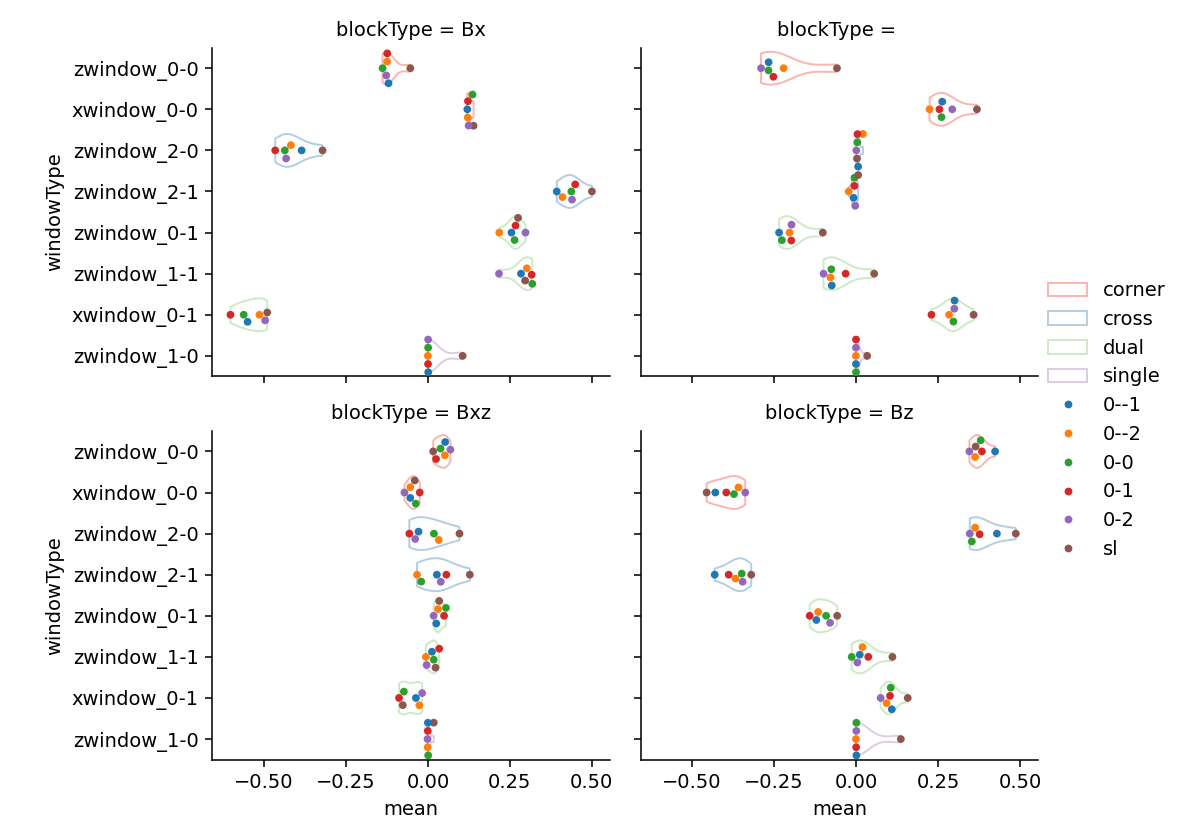

In [167]:

windowList = flowStats[flowStats["houseType"] != "sl"]["windowType"]                                                       
dfPlot = flowStats.loc[flowStats["windowType"].isin(windowList)]

sns.lmplot(data = dfPlot, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/windowKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(dfPlot, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "windowType", color = "1", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "windowType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowViolins', bbox_inches="tight")

g = sns.FacetGrid(dfPlot, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowViolins', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/groups/gorle/codes/miniconda3/en

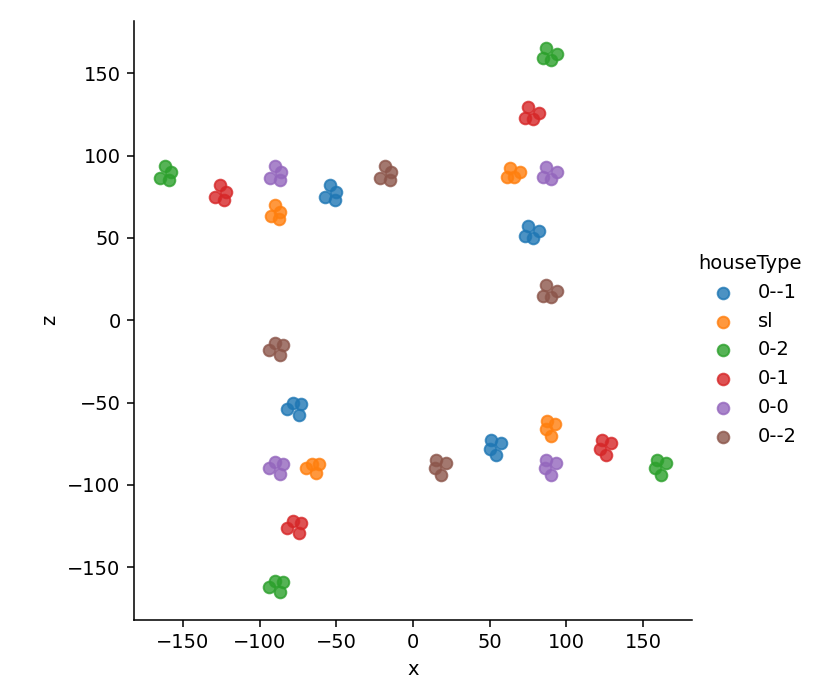

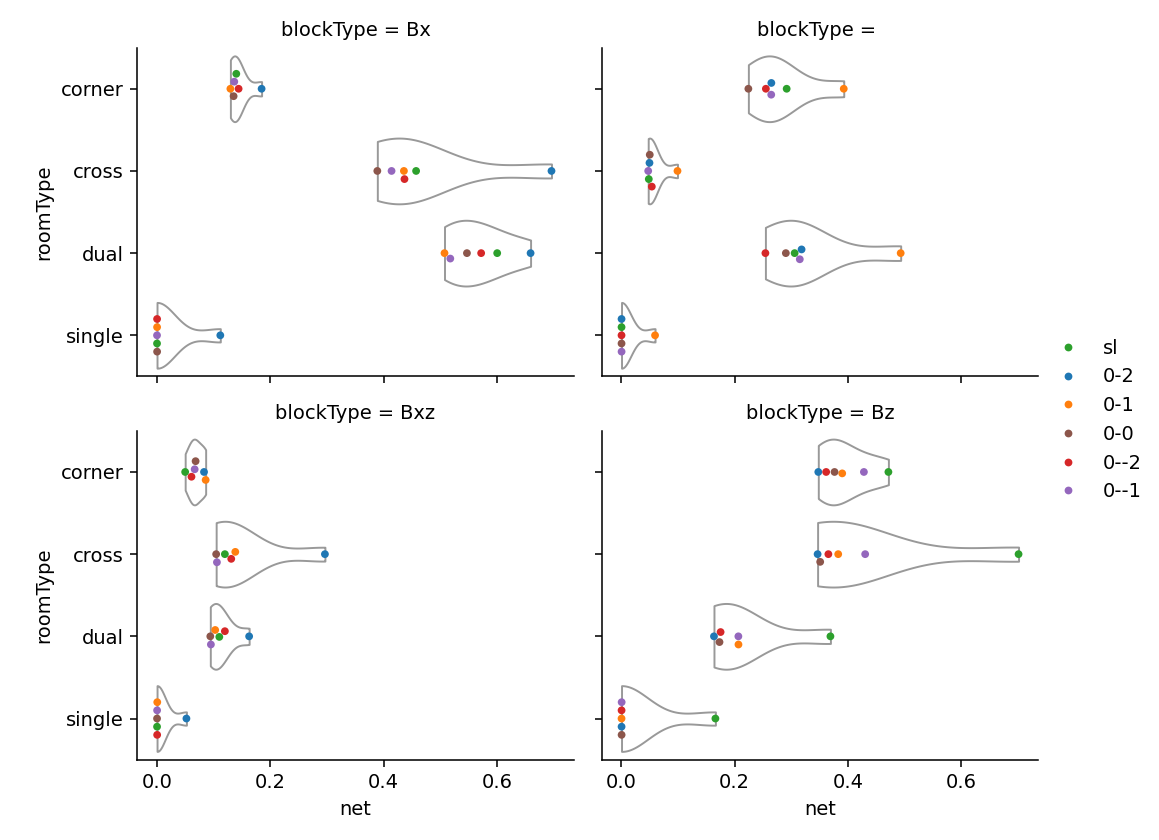

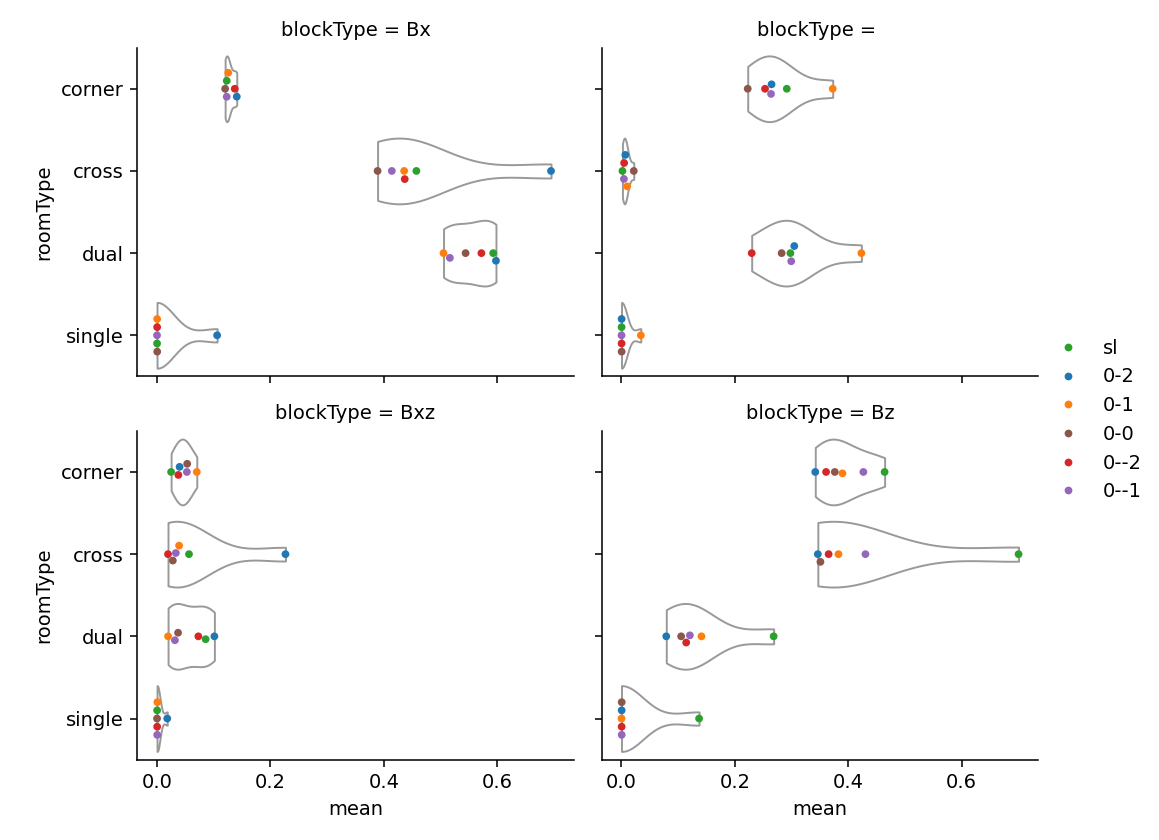

In [139]:
sns.lmplot(data = roomVentilation, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/roomKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "roomType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRoomViolins', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRoomViolins', bbox_inches="tight")

## Convergence

In [115]:
data = probes.statistics(
    names = [name for name in probes.probe_names if "door" not in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [],
    parrallel=False
    )

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


processing data took 9 seconds


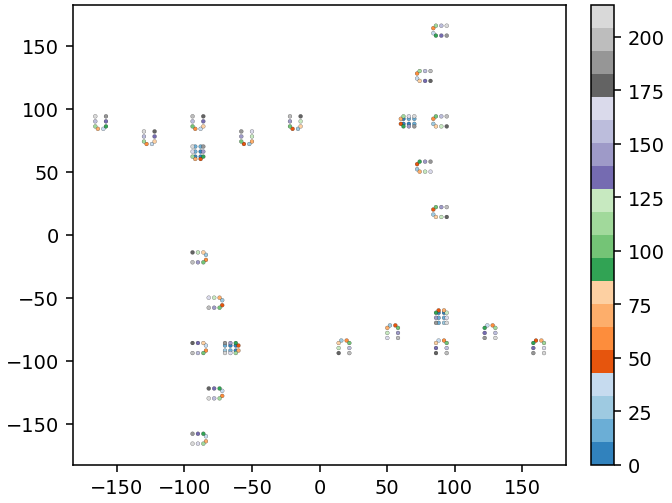

In [116]:
xPlot = data.index.values
yPlot = np.arange(len(data.keys()))

fig, ax=plt.subplots(1, 1, constrained_layout = True)
im=ax.scatter(flowStats.loc[data.keys(), 'x'], flowStats.loc[data.keys(), 'z'], s=4, c=yPlot, cmap='tab20c', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/dataMap', bbox_inches="tight")

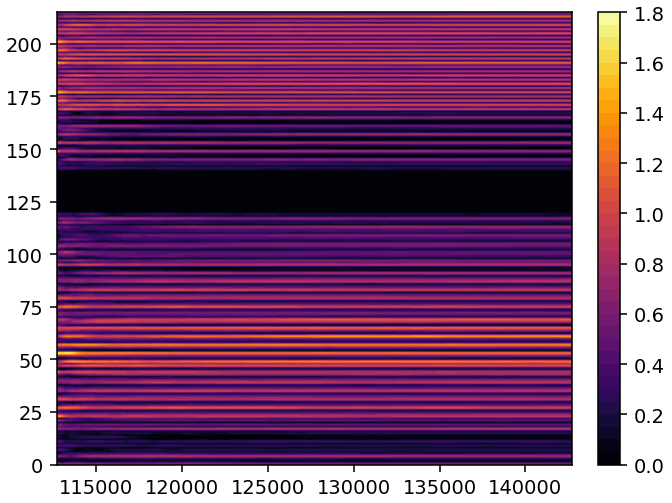

In [117]:
dataCumMean = probePost.cumulative_mean(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataCumMean.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)
# ax.set_yticks(yPlot)
# ax.set_yticklabels(dataCumMean.keys())

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourCumMean', bbox_inches="tight")

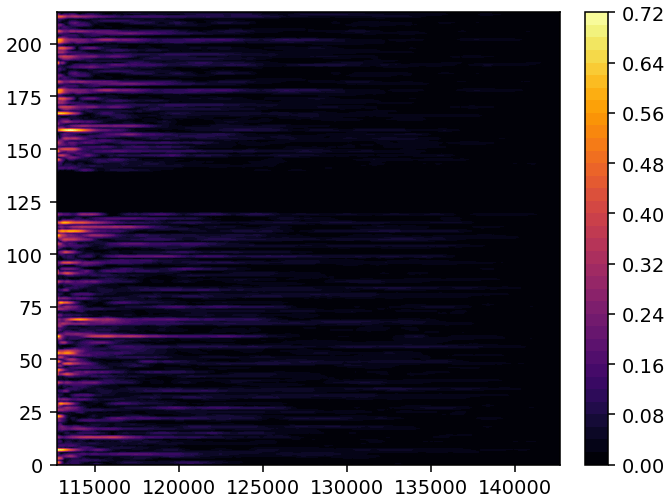

In [118]:
dataConv = probePost.convergence(dataCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataConv.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourConv', bbox_inches="tight")

/tmp/ipykernel_21640/2084037924.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(constrained_layout = True)


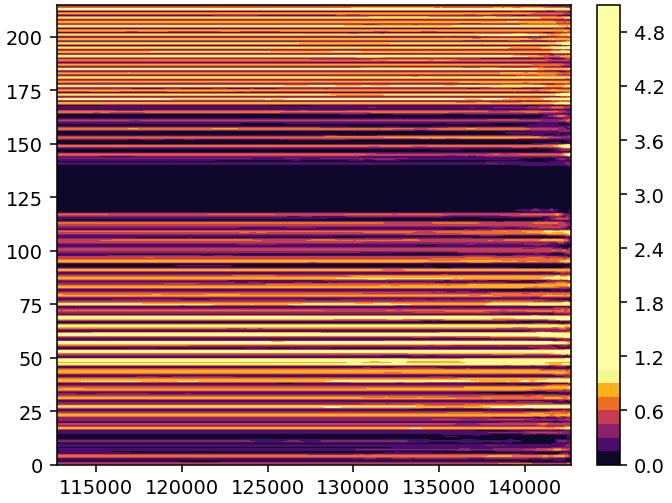

In [119]:
dataRevCumMean = probePost.reverse(data)
dataRevCumMean = probePost.cumulative_mean(dataRevCumMean)
dataRevCumMean = probePost.reverse(dataRevCumMean)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataRevCumMean.abs().T, cmap = "inferno", levels=40, vmax = 1)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourRevCumMean', bbox_inches="tight")

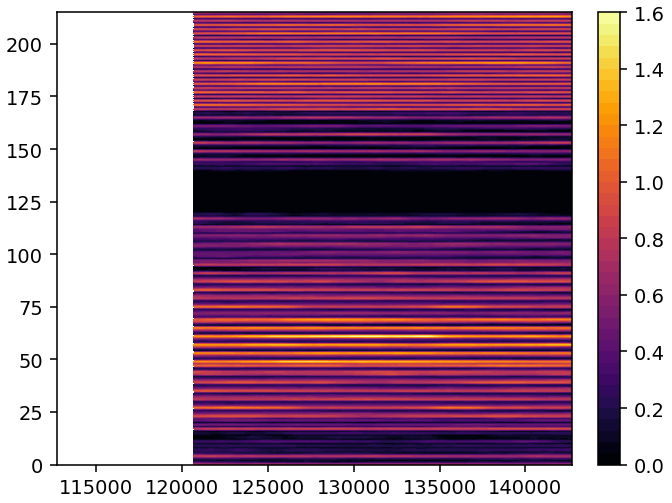

In [120]:
@utils.no_kwargs
@utils.dict_apply
def sma(df): 
    return df.rolling(8000).mean()
    
dataSMA = sma(data)

fig, ax = plt.subplots(constrained_layout = True)
im = ax.contourf(xPlot, yPlot, dataSMA.abs().T, cmap = "inferno", levels=40)
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourSMA', bbox_inches="tight")